### Sector Rotational Momentum Trading Program with RF Regression Predicitons

The program presented here is a sector rotational momentum program which incorporates RF regression predictions in addition to A_periods, B_periods, and S_periods scoring.

The ETF list evaluated is the same as in the Baseline model and is listed below:
- 'XLU'
- 'XLV'
- 'DIA'
- 'GDX'
- 'XLE'
- 'XLY'
- 'VNQ'
- 'XLK'
- 'XLF'
- 'XLP'
- 'IHI'
- 'XRT'
- 'RXI'
- 'IYW'
- 'VIS'
- 'KBE'
- 'SIL'
- 'FXU'
- 'SHY'

A combination of yfinance and WRDS ETF data is used. For A_periodss, B_periods, and S_periods scores, yahoo finance data is used, while for ML predcitions, WRDS data is used.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 10 10:42:09 2018

@author: Bryan Tarras (modified), Rosario (original)
"""

import pandas as pd
import numpy as np
import math
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import detrendPrice
import WhiteRealityCheckFor1

import yfinance as yf
#yf.pdr_override() # <== that's all it takes :-)

In [2]:
counter_risk_stock = 0 #Superceded variable can probably be deleted
counter_risk_bond = 0 #Superceded variable can probably be deleted

In [3]:
def getDate(dt):
    if type(dt) != str:
        return dt
    try:
        datetime_object = datetime.datetime.strptime(dt, '%Y-%m-%d')
    except Exception:
        datetime_object = datetime.datetime.strptime(dt, '%m/%d/%Y')
        return datetime_object
    else:
        return datetime_object

In [4]:
#Training Data Set Data
start_date_training = '2010-01-05'
end_date_training = '2016-12-30'

#Test Data Set Data
start_date_training = '2017-01-03'
end_date_training = '2018-08-06'

### The Cells below are to download the data sets for Training and Test Sets

Need to run it to generate the proper csv files

***Only need to run this once per stock_list combination

Below is to download the training data and test data and store in csv files with the suffix "_training" or "_test"

In [5]:
#Example1
# download dataframe
#data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
# download Panel
#data2 = pdr.get_data_yahoo(["SPY", "IWM"], start="2017-01-01", end="2017-04-30")
#example2
#start = datetime.datetime(2017, 1, 1)
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)
#data.to_csv("C:\\Users\\Rosario\\Documents\\NeuralNetworksMachineLearning\\LSTMReturnPrediction\\data\\YahooSPY.csv")

#start_date=datetime.datetime(2003, 1, 1)
start_date_training=datetime.datetime(2010, 1, 5)
#end_date= datetime.datetime.now()
end_date_training=datetime.datetime(2016, 12, 30)

start_date_test=datetime.datetime(2017, 1, 3)
#end_date= datetime.datetime.now()
end_date_test=datetime.datetime(2018, 8, 6)


stock_list = ['XLU','XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']
#stock_list = ["SPY", "BND", "TLT"]
#stock_list = ["SPY", "TLT"]
#stock_list = ["SPY", "TLT", "SHY"]


stock_str = ""
for i in range(len(stock_list)):
    stock_str  = stock_str + stock_list[i] + "."


#Below is for AP training data download    
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_training)
     df.drop(['Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Adj Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 
    

main_df.to_csv(stock_str+"AP_train.csv")


#Below is for normal prices training data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_training)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"train.csv")

#Below is for AP test data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_test, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"AP_test.csv")

#Below is for normal price test data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_test, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"test.csv")



### Testing Data Section
The secion bleow will read in the training data and proceed to run the trading algorithm on this training data set

In [6]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.train.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_train.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [7]:
dfP.shape

(1761, 19)

In [8]:
dfP.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,30.709999,31.299999,105.489998,48.169998,59.290001,30.110001,44.500000,23.240000,12.152721,26.680000,53.779999,18.084999,44.410000,58.400002,52.770000,22.180000,NaN,15.45,83.169998
2010-01-06,30.889999,31.620001,105.559998,49.340000,60.000000,30.150000,44.419998,22.980000,12.177092,26.660000,54.389999,18.250000,44.430000,57.990002,52.900002,22.469999,NaN,15.47,83.180000
2010-01-07,30.750000,31.730000,105.940002,49.099998,59.910000,30.400000,44.900002,22.889999,12.437043,26.660000,54.630001,18.299999,44.650002,57.770000,53.549999,23.410000,NaN,15.41,83.160004
2010-01-08,30.719999,31.780001,106.110001,49.840000,60.299999,30.389999,44.570000,23.040001,12.363932,26.570000,54.689999,18.260000,45.009998,58.209999,54.259998,23.320000,NaN,15.35,83.239998
2010-01-11,31.040001,31.959999,106.540001,50.169998,60.220001,30.330000,44.830002,22.950001,12.372055,26.639999,55.029999,18.205000,45.200001,57.930000,54.770000,23.330000,NaN,15.49,83.279999


In [9]:
dfAP.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2016-12-23,44.442898,66.537178,186.965958,19.084234,69.879646,79.567932,72.273666,47.078487,22.429367,48.298004,132.494278,42.660793,87.801529,119.185059,115.131683,41.815819,29.729496,24.856861,80.495987
2016-12-27,44.479473,66.671288,187.116196,19.607225,70.035233,79.876732,72.425667,47.270756,22.457905,48.288719,132.752167,43.073219,87.907364,119.741531,115.351059,41.986961,30.528627,24.912346,80.457802
2016-12-28,44.058903,66.163589,186.054825,19.972334,69.275581,79.326668,71.987488,46.847755,22.229618,47.991844,131.919022,42.555294,87.532143,118.589516,114.092064,41.597141,31.082760,24.671917,80.486427
2016-12-29,44.653187,66.278542,185.970322,21.462362,69.138275,79.220520,72.881737,46.857368,22.067909,48.214500,132.216583,42.440205,87.166534,118.501640,114.120667,41.245350,33.238281,24.912346,80.572304
2016-12-30,44.406326,66.039070,185.519440,20.643339,68.936935,78.554649,73.802818,46.492046,22.115473,47.973286,132.057877,42.267570,86.743217,117.398438,113.748695,41.330914,31.604418,24.718153,80.600952


In [11]:
#Reading in the predictions from the RF model

dfRF_C_train = pd.read_csv('rf-regression-ETF-train-predictions.csv')

print (dfRF_C_train.shape)

(1761, 20)


In [12]:
#dfRF_C_train = dfRF_C_train.drop('Unnamed: 0', axis=1)

In [13]:
dfRF_C_train.set_index('Date', inplace=True)

In [14]:
dfRF_C_train.head()

,FXU,GDX,KBE,RXI,VNQ,XLP,XRT,DIA,IHI,IYW,SHY,VIS,XLE,XLF,XLK,XLU,XLV,XLY,SIL
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,0.027159,0.118396,0.042858,-0.014150,0.086980,0.014257,0.021388,-0.011176,0.062483,-0.019973,0.005905,0.033681,-0.078609,-0.012390,-0.036402,-0.028507,-0.086966,0.062803,-0.107698
2010-01-06,0.027078,0.113383,0.043142,-0.013732,0.103964,0.015174,0.021113,-0.012051,0.016993,-0.020116,0.005905,0.034671,-0.077826,-0.012390,-0.036339,-0.025975,-0.088401,0.061742,-0.107330
2010-01-07,0.027310,0.112797,0.040094,-0.012659,0.086980,0.015102,0.020308,-0.011710,0.015272,-0.020209,0.005905,0.033987,-0.077223,-0.015280,-0.036184,-0.029321,-0.088959,0.061926,-0.106891
2010-01-08,0.019908,0.112249,0.034627,-0.017012,0.087549,0.013374,0.020840,-0.013082,0.009500,-0.020506,0.005905,0.033771,-0.076169,-0.015236,-0.037330,-0.029784,-0.090920,0.060992,-0.107014
2010-01-11,0.019047,0.117516,0.034206,-0.016798,0.087549,0.011487,0.021113,-0.013591,0.008844,-0.020486,0.005898,0.034121,-0.078405,-0.015341,-0.037778,-0.029684,-0.090831,0.060678,-0.107698


In [15]:
dfRF_C_train.tail()

,FXU,GDX,KBE,RXI,VNQ,XLP,XRT,DIA,IHI,IYW,SHY,VIS,XLE,XLF,XLK,XLU,XLV,XLY,SIL
Date,,,,,,,,,,,,,,,,,,,
2016-12-23,0.025461,0.030512,0.007493,0.050152,0.023815,0.053589,0.000004,0.037220,0.157978,0.101813,-0.000604,0.060144,-0.091637,-0.039124,0.074695,0.058579,0.069006,0.065841,NaN
2016-12-27,0.023245,0.027719,0.007614,0.051036,0.023722,0.055309,0.000004,0.040042,0.154601,0.101914,-0.000523,0.060300,-0.093262,-0.039124,0.074759,0.057808,0.067728,0.065841,NaN
2016-12-28,0.032654,0.028235,0.007820,0.057209,0.028947,0.056788,-0.000267,0.036609,0.157689,0.101964,-0.000586,0.060293,-0.103189,-0.038236,0.074796,0.058509,0.069580,0.065883,NaN
2016-12-29,0.029648,0.014701,0.007916,0.052375,0.025989,0.051716,0.000382,0.038625,0.155831,0.101725,-0.000629,0.060293,-0.102316,-0.038539,0.075100,0.058123,0.065765,0.065979,NaN
2016-12-30,0.029897,0.023819,0.001129,0.051808,0.008073,0.052367,0.000591,0.036475,0.153933,0.101553,-0.000686,0.060537,-0.105336,-0.041448,0.068728,0.058311,0.064384,0.065938,NaN


In [16]:
dfRF_C_train = dfRF_C_train[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [17]:
dfRF_C_train.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.028507,-0.086966,-0.011176,0.118396,-0.078609,0.062803,0.086980,-0.036402,-0.012390,0.014257,0.062483,0.021388,-0.014150,-0.019973,0.033681,0.042858,-0.107698,0.027159,0.005905
2010-01-06,-0.025975,-0.088401,-0.012051,0.113383,-0.077826,0.061742,0.103964,-0.036339,-0.012390,0.015174,0.016993,0.021113,-0.013732,-0.020116,0.034671,0.043142,-0.107330,0.027078,0.005905
2010-01-07,-0.029321,-0.088959,-0.011710,0.112797,-0.077223,0.061926,0.086980,-0.036184,-0.015280,0.015102,0.015272,0.020308,-0.012659,-0.020209,0.033987,0.040094,-0.106891,0.027310,0.005905
2010-01-08,-0.029784,-0.090920,-0.013082,0.112249,-0.076169,0.060992,0.087549,-0.037330,-0.015236,0.013374,0.009500,0.020840,-0.017012,-0.020506,0.033771,0.034627,-0.107014,0.019908,0.005905
2010-01-11,-0.029684,-0.090831,-0.013591,0.117516,-0.078405,0.060678,0.087549,-0.037778,-0.015341,0.011487,0.008844,0.021113,-0.016798,-0.020486,0.034121,0.034206,-0.107698,0.019047,0.005898


### In the cell blocks below we need to optimize the following:
    - Aperiods
    - Bperiods
    - Speriods
    
We should run with the following parameter spread:
    - Aperiods = [10, 15, 20, 30, 40, 50, 120, 200, 240, 300]
    - Bperiods = [10, 15, 20, 30, 40, 50, 120, 200, 240, 300]
    - Speriods = [1, 5, 10, 15, 20, 25, 30, 35]
    - Frequency = '20W-Thu'
    
Evaluation fo which ETF is to be selected will occur on the Aperiods score, Bperiods score, Speriods score, and the predictions from the RF model lagged at 20 weeks.

In [18]:
def stock_etf_optimization (Aperiods, Bperiods, Speriods, counter_risk_stock, df_place_holder):
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    #Aperiods = 10 #20 Default
    #Bperiods = 10 #66 Default
    #Speriods = 20 #20 Default
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
#######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_C_train.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_C_train.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
        
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        #Line below is where we multiply the returns stored in column_R by 0.33 for equal investment in all top 3 perfroming ETFs
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    #dfPRR['I'].plot()
    #plt.legend()
    #plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    df_place_holder = [(TotaAnnReturn*100),(CAGR*100),(round(sharpe,2)), (Aperiods), (Bperiods), (Speriods), (Frequency)]
    
    return (df_place_holder)

Need to make a dataframe that stores annual returns, CAGR, Sharpe Ratio, Average Return, Aperiods, Bperiods, frequency 

In [19]:
Aperiods = [10, 15, 20, 30, 40, 50]
Bperiods = [10, 15, 20, 30, 40, 50]
Speriods = [1, 5, 10, 15, 20, 25, 30, 35]
#frequency = ['8W-MON', '8W-TUE', '8W-WED', '8W-THU', '8W-FRI', '20W-MON', '20W-TUE', '20W-WED', '20W-THU', '20W-FRI', '40W-MON', '40W-TUE', '40W-WED', '40W-THU', '40W-FRI']

In [20]:
#Uncomment the below for testingpurposes only
#Aperiods = [10]
#Bperiods = [20]
#Speriods = [1]

In [21]:
df_place_holder = pd.DataFrame(np.nan, index=['results'], columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','frequency'])

In [22]:
df_stock_etf_optimal_list = [[0]*6]

In [23]:
counter = 0
counter_risk_stock = 0

In [24]:
for x in Aperiods:
    for z in Bperiods:
        for y in (Speriods):
            counter = counter + 1
            test = stock_etf_optimization (x,z,y,counter_risk_stock,df_place_holder)
            df_stock_etf_optimal_list.append(test)
            print (counter)

TotaAnnReturn = 64.196286
CAGR = 26.500000
Sharpe Ratio = 1.290000
1
TotaAnnReturn = 48.633866
CAGR = 22.720000
Sharpe Ratio = 1.440000
2
TotaAnnReturn = 39.517333
CAGR = 20.100000
Sharpe Ratio = 1.340000
3
TotaAnnReturn = 52.440323
CAGR = 23.710000
Sharpe Ratio = 1.550000
4
TotaAnnReturn = 73.914892
CAGR = 28.550000
Sharpe Ratio = 1.490000
5
TotaAnnReturn = 54.700206
CAGR = 24.280000
Sharpe Ratio = 1.560000
6
TotaAnnReturn = 59.259677
CAGR = 25.380000
Sharpe Ratio = 1.650000
7
TotaAnnReturn = 53.458124
CAGR = 23.970000
Sharpe Ratio = 1.550000
8
TotaAnnReturn = 49.033422
CAGR = 22.820000
Sharpe Ratio = 0.970000
9
TotaAnnReturn = 48.417642
CAGR = 22.660000
Sharpe Ratio = 1.430000
10
TotaAnnReturn = 52.209622
CAGR = 23.650000
Sharpe Ratio = 1.530000
11
TotaAnnReturn = 53.708053
CAGR = 24.030000
Sharpe Ratio = 1.550000
12
TotaAnnReturn = 45.229577
CAGR = 21.780000
Sharpe Ratio = 1.440000
13
TotaAnnReturn = 54.522259
CAGR = 24.240000
Sharpe Ratio = 1.560000
14
TotaAnnReturn = 54.522259
CAG

TotaAnnReturn = 38.510958
CAGR = 19.790000
Sharpe Ratio = 1.400000
118
TotaAnnReturn = 37.998802
CAGR = 19.630000
Sharpe Ratio = 1.390000
119
TotaAnnReturn = 39.049807
CAGR = 19.960000
Sharpe Ratio = 1.400000
120
TotaAnnReturn = 45.296849
CAGR = 21.800000
Sharpe Ratio = 0.930000
121
TotaAnnReturn = 40.275634
CAGR = 20.330000
Sharpe Ratio = 1.060000
122
TotaAnnReturn = 41.954302
CAGR = 20.840000
Sharpe Ratio = 1.330000
123
TotaAnnReturn = 34.596353
CAGR = 18.530000
Sharpe Ratio = 1.330000
124
TotaAnnReturn = 43.794254
CAGR = 21.370000
Sharpe Ratio = 1.400000
125
TotaAnnReturn = 43.794254
CAGR = 21.370000
Sharpe Ratio = 1.400000
126
TotaAnnReturn = 38.813730
CAGR = 19.880000
Sharpe Ratio = 1.310000
127
TotaAnnReturn = 43.481539
CAGR = 21.280000
Sharpe Ratio = 1.390000
128
TotaAnnReturn = 49.585429
CAGR = 22.970000
Sharpe Ratio = 0.980000
129
TotaAnnReturn = 44.799148
CAGR = 21.660000
Sharpe Ratio = 1.110000
130
TotaAnnReturn = 39.925648
CAGR = 20.230000
Sharpe Ratio = 1.200000
131
TotaAn

TotaAnnReturn = 37.539698
CAGR = 19.480000
Sharpe Ratio = 0.990000
234
TotaAnnReturn = 29.885688
CAGR = 16.880000
Sharpe Ratio = 1.020000
235
TotaAnnReturn = 35.810158
CAGR = 18.930000
Sharpe Ratio = 1.240000
236
TotaAnnReturn = 31.567606
CAGR = 17.490000
Sharpe Ratio = 1.050000
237
TotaAnnReturn = 36.499285
CAGR = 19.150000
Sharpe Ratio = 1.240000
238
TotaAnnReturn = 37.480197
CAGR = 19.470000
Sharpe Ratio = 1.270000
239
TotaAnnReturn = 36.110286
CAGR = 19.030000
Sharpe Ratio = 1.260000
240
TotaAnnReturn = 54.144302
CAGR = 24.140000
Sharpe Ratio = 1.020000
241
TotaAnnReturn = 62.063845
CAGR = 26.030000
Sharpe Ratio = 1.370000
242
TotaAnnReturn = 44.017385
CAGR = 21.440000
Sharpe Ratio = 1.400000
243
TotaAnnReturn = 58.222561
CAGR = 25.140000
Sharpe Ratio = 1.630000
244
TotaAnnReturn = 55.085434
CAGR = 24.380000
Sharpe Ratio = 1.600000
245
TotaAnnReturn = 71.175083
CAGR = 28.000000
Sharpe Ratio = 1.480000
246
TotaAnnReturn = 57.418109
CAGR = 24.940000
Sharpe Ratio = 1.640000
247
TotaAn

In [25]:
df_stock_etf_optimal=pd.DataFrame(df_stock_etf_optimal_list,columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','Frequency'])

In [26]:
print (df_stock_etf_optimal.nlargest(50, 'TotaAnnReturn'))

     TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods  \
281      80.465978  29.82          1.28        50        50         1   
5        73.914892  28.55          1.49        10        10        20   
46       71.175083  28.00          1.48        10        50        25   
246      71.175083  28.00          1.48        50        10        25   
40       69.362052  27.62          1.52        10        40        35   
200      69.362052  27.62          1.52        40        10        35   
69       68.645558  27.47          1.41        15        20        20   
109      68.645558  27.47          1.41        20        15        20   
36       66.576477  27.03          1.48        10        40        15   
196      66.576477  27.03          1.48        40        10        15   
71       66.361594  26.98          1.40        15        20        30   
72       66.361594  26.98          1.40        15        20        35   
111      66.361594  26.98          1.40        20  

In [27]:
print (df_stock_etf_optimal.nlargest(50, 'Sharpe Ratio'))

     TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods  \
19       53.994937  24.11          1.75        10        20        10   
99       53.994937  24.11          1.75        20        10        10   
27       52.004360  23.60          1.71        10        30        10   
31       52.776550  23.80          1.71        10        30        30   
147      52.004360  23.60          1.71        30        10        10   
151      52.776550  23.80          1.71        30        10        30   
28       53.164390  23.90          1.70        10        30        15   
148      53.164390  23.90          1.70        30        10        15   
30       52.801073  23.80          1.68        10        30        25   
150      52.801073  23.80          1.68        30        10        25   
23       50.243982  23.14          1.66        10        20        30   
24       50.243982  23.14          1.66        10        20        35   
39       53.176429  23.90          1.66        10  

The line below is for outputting results to a csv file.

In [28]:
df_stock_etf_optimal.to_csv('APS1052_df_stock_etf_optimal_training_results_top_one_with_prediction_RF_Regression.csv', header = True, index=True, encoding='utf-8')

#### Okay the next step is to use the optimal parameters from the training data identified above to plot an equity curve for the stock etfs

In [29]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

#dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.train.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.AP_train.csv', parse_dates=['Date'])

#dfP = dfP.sort_values(by='Date')
#dfAP = dfAP.sort_values(by='Date')
#dfP.set_index('Date', inplace = True)
#dfAP.set_index('Date', inplace = True)

In [30]:
def stock_etf_optimized_parameters():    
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 50 #20 Default
    Bperiods = 50 #66 Default
    Speriods = 1
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_C_train.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_C_train.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)

    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return (stock_etf_df_R1, stock_etf_df_R2, stock_etf_df_R3, stock_etf_df_R4, stock_etf_df_R5, stock_etf_df_Sharpe_1, stock_etf_df_Sharpe_2, stock_etf_df_Sharpe_3, stock_etf_df_Sharpe_4, stock_etf_df_Sharpe_5)

Number of times "XLU" is selected 0.000000 
Number of times "XLV" is selected 526.000000 
Number of times "DIA" is selected 48.000000 
Number of times "GDX" is selected 206.000000 
Number of times "XLE" is selected 164.000000 
Number of times "XLY" is selected 144.000000 
Number of times "VNQ" is selected 97.000000 
Number of times "XLK" is selected 58.000000 
Number of times "XLF" is selected 234.000000 
Number of times "XLP" is selected 12.000000 
Number of times "IHI" is selected 52.000000 
Number of times "XRT" is selected 44.000000 
Number of times "RXI" is selected 4.000000 
Number of times "IYW" is selected 14.000000 
Number of times "VIS" is selected 0.000000 
Number of times "KBE" is selected 7.000000 
Number of times "SIL" is selected 14.000000 
Number of times "FXU" is selected 5.000000 
Number of times "SHY" is selected 132.000000 


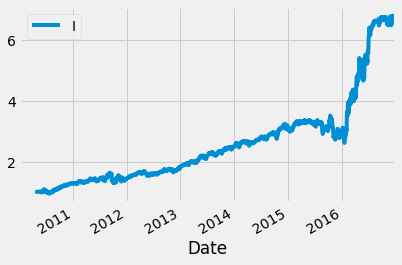

TotaAnnReturn = 80.465978
CAGR = 29.820000
Sharpe Ratio = 1.280000
Standard Deviation = 0.015495


In [31]:
stock_etf_df_R1, stock_etf_df_R2, stock_etf_df_R3, stock_etf_df_R4, stock_etf_df_R5, stock_etf_df_Sharpe_1, stock_etf_df_Sharpe_2, stock_etf_df_Sharpe_3, stock_etf_df_Sharpe_4, stock_etf_df_Sharpe_5 = stock_etf_optimized_parameters()

### Performance on test data set

What we want to do is take that df_stock_etf_optimal dataframe, extract the top 50 parameter combinations on the training data and run it on the test data to see which combinations performs best. Use the best as the total portfolio parameters to be used on the entire dataset.

In [32]:
df_stock_optimal_training_results = df_stock_etf_optimal.nlargest(50, 'TotaAnnReturn')
df_stock_optimal_training_results = df_stock_optimal_training_results.drop(['TotaAnnReturn', 'CAGR', 'Sharpe Ratio'], axis = 1)

In [33]:
df_stock_optimal_training_results = df_stock_optimal_training_results.reset_index(drop = True) 

In [34]:
df_stock_optimal_training_results.head(100)

,Aperiods,Bperiods,Speriods,Frequency
0,50,50,1,20W-THU
1,10,10,20,20W-THU
2,10,50,25,20W-THU
3,50,10,25,20W-THU
4,10,40,35,20W-THU
5,40,10,35,20W-THU
6,15,20,20,20W-THU
7,20,15,20,20W-THU
8,10,40,15,20W-THU
9,40,10,15,20W-THU


In [35]:
Aperiods_training = []
Bperiods_training = []
Speriods_training = []

clm = list(df_stock_optimal_training_results)
for x in range (0,50):
    Aperiods_training.append(df_stock_optimal_training_results['Aperiods'][x])
    Bperiods_training.append(df_stock_optimal_training_results['Bperiods'][x])
    Speriods_training.append(df_stock_optimal_training_results['Speriods'][x])

print (Aperiods_training, Bperiods_training, Speriods_training)

[50, 10, 10, 50, 10, 40, 15, 20, 10, 40, 15, 15, 20, 20, 10, 40, 10, 40, 15, 20, 10, 40, 10, 10, 20, 15, 40, 10, 20, 10, 50, 10, 40, 15, 20, 10, 20, 10, 30, 15, 50, 40, 15, 20, 10, 50, 40, 50, 10, 40] [50, 10, 50, 10, 40, 10, 20, 15, 40, 10, 20, 20, 15, 15, 40, 10, 40, 10, 20, 15, 40, 10, 10, 20, 10, 40, 15, 20, 10, 50, 10, 40, 10, 20, 15, 10, 20, 30, 10, 50, 15, 40, 20, 15, 50, 10, 50, 40, 40, 10] [1, 20, 25, 25, 35, 35, 20, 20, 15, 15, 30, 35, 30, 35, 5, 5, 25, 25, 25, 25, 20, 20, 1, 20, 20, 1, 1, 5, 5, 5, 5, 10, 10, 15, 15, 30, 5, 5, 5, 1, 1, 1, 10, 10, 15, 15, 1, 1, 1, 1]


With the best 50 results from the training data set stored in the respective lists Aperiods_training, Bperiods_training, and frequency_training, the function below will be called to iterate over these combinations to determine perfromane on the test data set.

In [36]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.test.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_test.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [37]:
print (dfP.shape)
print (dfAP.shape)

(402, 19)
(402, 19)


In [38]:
dfP = dfP.drop(dfP.index[0])
dfAP = dfAP.drop(dfAP.index[0])

In [39]:
print (dfP.shape)
print (dfAP.shape)

(401, 19)
(401, 19)


In [40]:
dfP.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2018-08-01,52.450001,88.949997,253.110001,21.110001,76.050003,110.720001,82.519997,71.559998,27.950001,53.119999,208.710007,49.049999,116.129997,184.350006,143.289993,48.580002,27.25,26.129999,83.059998
2018-08-02,52.709999,89.279999,253.100006,20.940001,75.629997,111.480003,82.190002,72.459999,27.959999,53.660000,210.380005,49.560001,116.209999,187.070007,143.289993,49.009998,26.90,26.379999,83.110001
2018-08-03,53.299999,89.809998,254.389999,21.160000,75.239998,111.860001,83.080002,72.720001,28.120001,54.290001,210.160004,49.990002,116.769997,187.710007,143.479996,48.860001,27.23,26.590000,83.120003
2018-08-06,53.340000,89.970001,254.850006,20.900000,75.519997,112.610001,82.970001,73.110001,28.270000,54.340000,210.559998,50.290001,116.620003,189.210007,143.789993,48.900002,26.90,27.059999,83.139999
2018-08-07,53.259998,89.980003,256.119995,20.660000,76.080002,113.129997,82.820000,73.389999,28.400000,54.009998,210.270004,50.709999,117.730003,189.639999,144.770004,49.040001,26.84,27.030001,83.110001


In [41]:
#Reading in the predictions from the RF model

dfRF_test = pd.read_csv('rf-regression-ETF-predictions.csv')

print (dfRF_test.shape)

(401, 20)


In [42]:
dfRF_test.set_index('Date', inplace=True)

In [43]:
dfRF_test = dfRF_test[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [44]:
dfRF_test.head()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2017-01-04,0.058351,0.044858,0.033386,0.006319,-0.102622,0.065891,0.004815,0.068289,-0.042855,0.049467,0.139368,0.002914,0.051808,0.098689,0.059921,0.008071,-0.166947,0.017864,-0.000847
2017-01-05,0.035078,-0.001332,0.033038,0.002407,-0.104275,0.065320,0.002876,0.067922,-0.039525,0.042048,0.114919,0.004532,0.050895,0.093501,0.049602,0.002215,-0.167207,0.012407,-0.000570
2017-01-06,0.032564,-0.001410,0.033169,-0.003827,-0.099552,0.065224,0.003755,0.066739,-0.041595,0.040538,0.116460,0.005779,0.050848,0.094053,0.049675,0.000958,-0.165896,0.016137,-0.000803
2017-01-09,0.017822,-0.002175,0.033206,-0.011688,-0.110567,0.057765,0.011785,0.066995,-0.041595,0.041601,0.109333,0.005779,0.050848,0.094461,0.049479,0.007706,-0.165118,0.006350,-0.000622
2017-01-10,0.053540,-0.003089,0.035488,-0.004009,-0.108514,0.058361,0.011041,0.065273,-0.041524,0.044903,0.108174,0.023374,-0.010892,0.093205,0.048540,0.007338,-0.165576,0.006388,-0.000673


In [45]:
def stock_etf_performance_test_set (Aperiods, Bperiods, Speriods, counter_risk_stock, df_place_holder_test_performance):
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    #Aperiods = 10 #20 Default
    #Bperiods = 10 #66 Default
    #Speriods = 20 #20 Default
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
#######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_test.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_test.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
    #dfChoice.to_csv('dfChoice_testing.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
        
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        #Line below is where we multiply the returns stored in column_R by 0.33 for equal investment in all top 3 perfroming ETFs
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    #dfPRR['I'].plot()
    #plt.legend()
    #plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    df_place_holder_test_performance = [(TotaAnnReturn*100),(CAGR*100),(round(sharpe,2)), (Aperiods), (Bperiods), (Speriods), (Frequency)]
    
    return (df_place_holder_test_performance)

In [46]:
df_place_holder_test_performance = pd.DataFrame(np.nan, index=['results'], columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','frequency'])

df_stock_etf_test_performance = [[0]*6]

In [47]:
# CHANGE THE 2 BELOW TO 50 ONCE UP AND RUNNING, AND THE 1 TO A 0
for x in range (0,50):
    test_Aperiods = df_stock_optimal_training_results['Aperiods'][x]
    test_Bperiods = df_stock_optimal_training_results['Bperiods'][x]
    test_Speriods = df_stock_optimal_training_results['Speriods'][x]
    counter = counter + 1
    test = stock_etf_performance_test_set (test_Aperiods,test_Bperiods,test_Speriods,counter_risk_stock,df_place_holder_test_performance)
    df_stock_etf_test_performance.append(test)
    print (counter)
    

TotaAnnReturn = 18.772683
CAGR = 17.290000
Sharpe Ratio = 1.320000
289
TotaAnnReturn = 13.171484
CAGR = 12.310000
Sharpe Ratio = 1.140000
290
TotaAnnReturn = 20.828284
CAGR = 19.080000
Sharpe Ratio = 1.490000
291
TotaAnnReturn = 20.828284
CAGR = 19.080000
Sharpe Ratio = 1.490000
292
TotaAnnReturn = 14.821487
CAGR = 13.790000
Sharpe Ratio = 1.170000
293
TotaAnnReturn = 14.821487
CAGR = 13.790000
Sharpe Ratio = 1.170000
294
TotaAnnReturn = 19.089272
CAGR = 17.560000
Sharpe Ratio = 1.370000
295
TotaAnnReturn = 19.089272
CAGR = 17.560000
Sharpe Ratio = 1.370000
296
TotaAnnReturn = 6.428400
CAGR = 6.130000
Sharpe Ratio = 0.750000
297
TotaAnnReturn = 6.428400
CAGR = 6.130000
Sharpe Ratio = 0.750000
298
TotaAnnReturn = 16.444324
CAGR = 15.240000
Sharpe Ratio = 1.290000
299
TotaAnnReturn = 17.181563
CAGR = 15.890000
Sharpe Ratio = 1.320000
300
TotaAnnReturn = 16.444324
CAGR = 15.240000
Sharpe Ratio = 1.290000
301
TotaAnnReturn = 17.181563
CAGR = 15.890000
Sharpe Ratio = 1.320000
302
TotaAnnRet

In [48]:
print (df_stock_etf_test_performance)

[[0, 0, 0, 0, 0, 0], [18.772682588463077, 17.29, 1.32, 50, 50, 1, '20W-THU'], [13.171483866414574, 12.31, 1.14, 10, 10, 20, '20W-THU'], [20.82828376841269, 19.08, 1.49, 10, 50, 25, '20W-THU'], [20.82828376841269, 19.08, 1.49, 50, 10, 25, '20W-THU'], [14.821487160027422, 13.79, 1.17, 10, 40, 35, '20W-THU'], [14.821487160027422, 13.79, 1.17, 40, 10, 35, '20W-THU'], [19.089271863222347, 17.560000000000002, 1.37, 15, 20, 20, '20W-THU'], [19.089271863222347, 17.560000000000002, 1.37, 20, 15, 20, '20W-THU'], [6.428399618394106, 6.13, 0.75, 10, 40, 15, '20W-THU'], [6.428399618394106, 6.13, 0.75, 40, 10, 15, '20W-THU'], [16.444323808420055, 15.24, 1.29, 15, 20, 30, '20W-THU'], [17.181562962172656, 15.89, 1.32, 15, 20, 35, '20W-THU'], [16.444323808420055, 15.24, 1.29, 20, 15, 30, '20W-THU'], [17.181562962172656, 15.89, 1.32, 20, 15, 35, '20W-THU'], [18.991018540755803, 17.48, 1.2, 10, 40, 5, '20W-THU'], [18.991018540755803, 17.48, 1.2, 40, 10, 5, '20W-THU'], [14.821487160027422, 13.79, 1.17, 10

In [49]:
df_stock_etf_optimal_test_results=pd.DataFrame(df_stock_etf_test_performance,columns=['TotaAnnReturn','CAGR','Sharpe Ratio','Aperiods','Bperiods','Speriods','Frequency'])

In [50]:
print (df_stock_etf_optimal_test_results.nlargest(50, 'TotaAnnReturn'))

    TotaAnnReturn   CAGR  Sharpe Ratio  Aperiods  Bperiods  Speriods Frequency
3       20.828284  19.08          1.49        10        50        25   20W-THU
4       20.828284  19.08          1.49        50        10        25   20W-THU
7       19.089272  17.56          1.37        15        20        20   20W-THU
8       19.089272  17.56          1.37        20        15        20   20W-THU
15      18.991019  17.48          1.20        10        40         5   20W-THU
16      18.991019  17.48          1.20        40        10         5   20W-THU
30      18.991019  17.48          1.20        10        50         5   20W-THU
31      18.991019  17.48          1.20        50        10         5   20W-THU
1       18.772683  17.29          1.32        50        50         1   20W-THU
47      18.772683  17.29          1.32        40        50         1   20W-THU
48      18.772683  17.29          1.32        50        40         1   20W-THU
26      17.861797  16.49          1.19        15    

In [51]:
df_stock_etf_optimal_test_results.to_csv('df_stock_etf_optimal_test_results_top_50_training_results_on_test_data_Top_1_ETFs_RF_Regression.csv', header = True, index=True, encoding='utf-8')

With the best performing parameter combination from the training set on the test set identified, lets see the equity curve for the combination that performs best in both sets. To determine this offline analysis of the two outputted CSV files occured. After reviewing the two lists the best parameter combination was found to be:
- Aperiods = 50
- Bperiods = 50
- Speriods = 1

Finally we will run it across the entire dataset (training + test) with optimized parameters to get a annual return and sharpe ratio for the 2010-2019 data.

Start with loading the test set.

In [222]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

#dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.test.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.FSTA.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FNCL.XAR.FXU.SHY.AP_test.csv', parse_dates=['Date'])

#dfP = dfP.sort_values(by='Date')
#dfAP = dfAP.sort_values(by='Date')
#dfP.set_index('Date', inplace = True)
#dfAP.set_index('Date', inplace = True)

In [52]:
def stock_etf_optimized_parameters_test_set():  
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 50 #20 Default
    Bperiods = 50 #66 Default
    Speriods = 1
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_test.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_test.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return ()

Number of times "XLU" is selected 0.000000 
Number of times "XLV" is selected 24.000000 
Number of times "DIA" is selected 93.000000 
Number of times "GDX" is selected 0.000000 
Number of times "XLE" is selected 19.000000 
Number of times "XLY" is selected 65.000000 
Number of times "VNQ" is selected 1.000000 
Number of times "XLK" is selected 64.000000 
Number of times "XLF" is selected 6.000000 
Number of times "XLP" is selected 4.000000 
Number of times "IHI" is selected 12.000000 
Number of times "XRT" is selected 6.000000 
Number of times "RXI" is selected 2.000000 
Number of times "IYW" is selected 63.000000 
Number of times "VIS" is selected 0.000000 
Number of times "KBE" is selected 1.000000 
Number of times "SIL" is selected 0.000000 
Number of times "FXU" is selected 20.000000 
Number of times "SHY" is selected 21.000000 


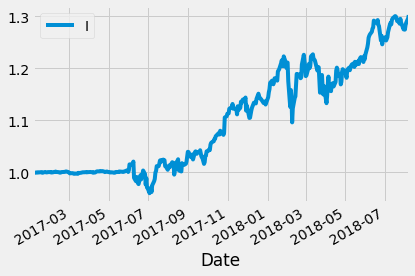

TotaAnnReturn = 18.772683
CAGR = 17.290000
Sharpe Ratio = 1.320000
Standard Deviation = 0.008362


In [53]:
testing = stock_etf_optimized_parameters_test_set()

Same parameters on whole dataset for trading program which selects only the top ETF for investment.

In [225]:
#Example1
# download dataframe
#data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
# download Panel
#data2 = pdr.get_data_yahoo(["SPY", "IWM"], start="2017-01-01", end="2017-04-30")
#example2
#start = datetime.datetime(2017, 1, 1)
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)
#data.to_csv("C:\\Users\\Rosario\\Documents\\NeuralNetworksMachineLearning\\LSTMReturnPrediction\\data\\YahooSPY.csv")

#start_date=datetime.datetime(2003, 1, 1)
start_date_training=datetime.datetime(2010, 1, 5)
#end_date= datetime.datetime.now()
#end_date_training=datetime.datetime(2016, 12, 30)

#start_date_test=datetime.datetime(2017, 1, 3)
#end_date= datetime.datetime.now()
end_date_test=datetime.datetime(2018, 8, 6)


stock_list = ['XLU','XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']
#stock_list = ["SPY", "BND", "TLT"]
#stock_list = ["SPY", "TLT"]
#stock_list = ["SPY", "TLT", "SHY"]


stock_str = ""
for i in range(len(stock_list)):
    stock_str  = stock_str + stock_list[i] + "."


#Below is for AP training data download    
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_test)
     df.drop(['Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Adj Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 
    

main_df.to_csv(stock_str+"AP_whole.csv")


#Below is for normal prices training data download 
main_df = pd.DataFrame()

for stock in range(len(stock_list)):
     df = pdr.get_data_yahoo(stock_list[stock], start=start_date_training, end=end_date_test)
     df.drop(['Adj Close','High', 'Low' , 'Open', 'Volume'], axis=1, inplace=True)
     df.rename(columns={'Close': stock_list[stock]}, inplace=True)
     if main_df.empty:
         main_df = df
     else:
        main_df = main_df.join(df) 

main_df.to_csv(stock_str+"whole.csv")

In [74]:
#start = datetime.datetime(2017, 1, 1)
#end = datetime.datetime.now()
#symbol = 'SPY'
#data = pdr.get_data_yahoo(symbol, start=start, end=end)

#All COLUMN_NAMES are capitalized
#IMPORTANT: ALL ETF LISTS  MUST END WITH SHY ETF (=rightmost column of the dataframe)
#dfP are the prices, used for the calculation of trading signals
#dfAP are the adjusted prices, used for the calculation of portfolio returns



#dfP = pd.read_csv('SPY.TLT.csv', parse_dates=['Date'])
#dfAP = pd.read_csv('SPY.TLT.AP.csv', parse_dates=['Date'])

dfP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.whole.csv', parse_dates=['Date'])
dfAP = pd.read_csv('XLU.XLV.DIA.GDX.XLE.XLY.VNQ.XLK.XLF.XLP.IHI.XRT.RXI.IYW.VIS.KBE.SIL.FXU.SHY.AP_whole.csv', parse_dates=['Date'])

dfP = dfP.sort_values(by='Date')
dfAP = dfAP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)
dfAP.set_index('Date', inplace = True)

In [75]:
print(dfP.shape)
print(dfAP.shape)

(2163, 19)
(2163, 19)


In [76]:
dfP = dfP.drop(dfP.index[0])
dfAP = dfAP.drop(dfAP.index[0])

In [77]:
#Reading in the predictions from the RF model

dfRF_total = pd.read_csv('rf-regression-ETF-train-predictions_whole_dataset.csv')

print (dfRF_total.shape)

(2162, 20)


In [78]:
dfRF_total.set_index('Date', inplace=True)

In [79]:
dfRF_total = dfRF_total[['XLU', 'XLV','DIA','GDX','XLE','XLY','VNQ','XLK','XLF','XLP','IHI','XRT','RXI','IYW','VIS','KBE','SIL','FXU','SHY']]

In [80]:
dfRF_total.tail()

,XLU,XLV,DIA,GDX,XLE,XLY,VNQ,XLK,XLF,XLP,IHI,XRT,RXI,IYW,VIS,KBE,SIL,FXU,SHY
Date,,,,,,,,,,,,,,,,,,,
2018-08-01,0.027095,-0.037582,-0.046853,-0.211984,-0.104101,0.049373,-0.017876,0.059426,-0.051218,-0.017848,0.003641,-0.295140,0.025086,0.089961,0.04978,-0.001085,NaN,0.023381,-0.001523
2018-08-02,0.069582,-0.037124,-0.046646,-0.206132,-0.103875,0.049373,-0.017793,0.057960,-0.051662,-0.016468,0.003641,-0.294763,0.025138,0.089987,0.04978,-0.000398,NaN,0.029670,-0.001432
2018-08-03,0.046420,-0.037195,-0.046778,-0.206132,-0.103875,0.049373,-0.017793,0.049855,-0.050592,-0.015626,0.003641,-0.247871,0.025159,0.089433,0.04978,0.000382,NaN,0.025501,-0.001432
2018-08-06,0.027122,-0.037355,-0.045409,-0.206556,-0.107519,0.049373,-0.017957,0.050254,-0.050592,-0.017542,0.003641,-0.169277,0.025011,0.089807,0.04978,0.000033,NaN,0.023149,-0.001432
2018-08-07,0.026824,-0.037288,-0.045431,-0.206556,-0.107914,0.049373,-0.018000,0.024082,-0.050632,-0.017310,0.003641,-0.148139,0.025011,0.089765,0.04978,-0.000620,NaN,0.017349,-0.001445


In [85]:
def stock_etf_optimized_parameters_full_dataset_top_ETF_only():    
     #logReturns = 1 means log returns will be used in the calculation of portfolio returns, 0 means pct_changes
    #momentum = 1 means A and B returns are ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #volmomentum = 1 volatility ranked in increasing order (momentum), 0 in decreasing order (reversion to the mean)
    #calendar_month = 1 means trading respects the beginning and end of each calendar month, 0 it pays no attention to it
    #month is used if calendar_month is set to 1
    #month = 1 means every month, 2 means every other month, 3 means every third month
    #week is used if calendar_month is set to 0, no attention will be paid to beginning and end of months
    #week = 1 means every weak, 2 means every other week, 3 means every third week, 4 means every fourth week
    #if week is used trading always occurs on a Tuesday
    #the selection of the ETF is based on maximum weighted score of: A returns, B returns and volatility
    #Frequency="W" every weeek, "2W" for every 2 weeks, "3W" every 3 weeks etc
    #Frequency="W-TUE" every Tuesday, "2W-TUE" for every 2 Tuesdats, "3W-TUE" every 3 Tudsdays etc
    #Frequency= "BM" every month, "2BM" for every 2 months, "3BM" every 3 months etc; B relates to business days; 31 or previous business day if necessary
    #Frequency="SM" on the middle (15) and end (31) of the month, or previous business day if necessary
    #Delay = 1 if the trade occurs instantaneously with the signal, 2 if the trade occurs 1 day after the signal
    
    #regime 40 40 till 2015, then 120 200
    logReturns = 0
    momentum = 1
    volmomentum = 0 #do not change
    Aperiods = 50 #20 Default
    Bperiods = 50 #66 Default
    Speriods = 1
    Zperiods = 200
    CashFilter = 0
    MAperiods = 200 #for the cash filter
    Zboundary = -1.5 #alternative cash filter
    Frequency = "20W-THU" #8W-FRI= 40 days, #40W-FRI = 200 days
    Delay = 1
    #Frequency = "2W-FRI" 
    counter = 0
    
    #dfA contains a short moving average of the daily percent changes, calculated for each ETF
    #dfB contains a long moving average of the daily percent changes, calculated for each ETF
    #dfS contains the annualized volatility, calculated for each ETF
    #dfMA contains 200 MA of price
    #dfDetrebd contains the detrended AP prices (for White's reality test)
    
    dfA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfB = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfS = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfZ = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfMA = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    dfDetrend = dfP.drop(labels=None, axis=1, columns=dfP.columns)
    
    #calculating the three performance measures in accordance with their windows
    
    dfA = dfP.pct_change(periods=Aperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfB = dfP.pct_change(periods=Bperiods-1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    dfR = dfP.pct_change(periods=1, fill_method='pad', limit=None, freq=None) #is counting window from 0
    
    columns = dfP.shape[1]
    for column in range(columns):
        dfS[dfP.columns[column]] = (dfR[dfP.columns[column]].rolling(window=Speriods).std())*math.sqrt(252)
        dfZ[dfP.columns[column]] = (dfP[dfP.columns[column]]-dfP[dfP.columns[column]].rolling(window=Zperiods).mean())/dfP[dfP.columns[column]].rolling(window=Zperiods).std()
        dfMA[dfP.columns[column]] = (dfP[dfP.columns[column]].rolling(window=MAperiods).mean())
        dfDetrend[dfAP.columns[column]] =  detrendPrice.detrendPrice(dfAP[dfAP.columns[column]]).values
    
    #Ranking each ETF w.r.t. short moving average of returns
    dfA_ranks = dfP.copy(deep=True)
    dfA_ranks[:] = 0
    
    columns = dfA_ranks.shape[1]
    rows = dfA_ranks.shape[0]
    
    #this loop takes each row of the A dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the A_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfA.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum, best is ETF with largest return
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is ETF with lowest return
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfA_ranks.iat[row, column] = ranks[column]
    
    dfB_ranks = dfP.copy(deep=True)
    dfB_ranks[:] = 0
    
    columns = dfB_ranks.shape[1]
    rows = dfB_ranks.shape[0]
    
    #this loop takes each row of the B dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the B_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfB.iloc[row].values
        if momentum == 1:
            temp = arr_row.argsort() #sort momentum
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion 
        ranks = np.empty_like(temp) 
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfB_ranks.iat[row, column] = ranks[column]
    
    dfS_ranks = dfP.copy(deep=True)
    dfS_ranks[:] = 0
    
    columns = dfS_ranks.shape[1]
    rows = dfS_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfS.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfS_ranks.iat[row, column] = ranks[column]
        
    
    #######ADDTION OF RANDOM FOREST PREDICTIONS 

    dfRF_ranks = dfRF_total.copy(deep=True)
    dfRF_ranks[:] = 0
    
    columns = dfRF_ranks.shape[1]
    rows = dfRF_ranks.shape[0]
    
    #this loop takes each row of the dfS dataframe, puts the row into an array, 
    #within the array the contents are ranked, 
    #then the ranks are placed into the dfS_ranks dataframe one by one
    for row in range(rows):
        arr_row = dfRF_total.iloc[row].values
        if volmomentum == 1:
            temp = arr_row.argsort() #sort momentum, best is highest volatility
        else:
            temp = (-arr_row).argsort()[:arr_row.size] #sort reversion, best is lowest volatility
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(1,len(arr_row)+1)
        for column in range(columns):
            dfRF_ranks.iat[row, column] = ranks[column]
    
    #print (dfA_ranks.shape)
    #print (dfB_ranks.shape)
    #print (dfS_ranks.shape)
    #print (dfRF_ranks.shape)
    
    
    
    
    #Weights of the varous ranks ####################################################################################
    #dfA_ranks = dfA_ranks.multiply(.3) #.3 default 
    dfA_ranks = dfA_ranks.multiply(.25) #.3 default
    #dfB_ranks = dfB_ranks.multiply(.4) #.4 default
    dfB_ranks = dfB_ranks.multiply(.25) #.4 default
    #dfS_ranks = dfS_ranks.multiply(.3) #.3 default
    dfS_ranks = dfS_ranks.multiply(.25) #.3 default
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######
    #Using a negative weight here as lowest rank is the ETF with the highest prediction, and as such we want it to be
    #the least penialized
    dfRF_ranks = dfRF_ranks.multiply(-0.25)
    
    
    #dfA_ranks.to_csv('dfA_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfB_ranks.to_csv('dfB_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfS_ranks.to_csv('dfS_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    #dfRF_ranks.to_csv('dfRF_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    
    dfAll_ranks = dfA_ranks.add(dfB_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfS_ranks, fill_value=0)
    dfAll_ranks = dfAll_ranks.add(dfRF_ranks, fill_value=0)
    
    ######THIS IS WHERE WE CAN ADD IN THE RANDOM FOREST SCORING######

    
    
    #dfAll_ranks.to_csv('dfAll_ranks_RF_Class.csv', header = True, index=True, encoding='utf-8')
    
    ### THIS IS THE DATAFRAME I WANT "dfAll_ranks" ###
    
    #Choice is the dataframe where the ETF with the maximum score is identified
    dfChoice = dfP.copy(deep=True)
    dfChoice[:] = 0
    rows = dfChoice.shape[0]
    columns = dfChoice.shape[1]
    
    #this loop takes each row of the All-ranks dataframe, puts the row into an array, 
    #within the array the contents scanned for the maximum element 
    #then the maximum element is placed into the Choice dataframe
    for row in range(rows):
        arr_row = dfAll_ranks.iloc[row].values
        #print (arr_row)
        if momentum == 0:
             arr_row = arr_row[0:len(arr_row)-1] #don't rank SHY (the last column) if doing reversion to mean trading
        max_arr_column = np.argmax(arr_row, axis=0) #gets the INDEX of the max
        #three_max_arr_column = np.argpartition(arr_row, -3)[-3:]
        #print (max_arr_column)
        #three_max_arr_column = np.argsort(arr_row)[-3:]
        
        if CashFilter == 1:
            if (dfP[dfP.columns[max_arr_column]][row] >= dfMA[dfMA.columns[max_arr_column]][row]): #200MA condition for cash filter
            #if (dfZ[dfZ.columns[max_arr_column]][row] > Zboundary): #alternative cash filter
                dfChoice.iat[row, max_arr_column] = 1
            else:
                dfChoice.iat[row, dfP.columns.get_loc("SHY")] = 1
        else:
            #Below is the code that extracts the top 3 performing ETFs and assigns a 1 to them in the dataframe dfChoice
            #All other not chosen ETFs are assigned a 0
            #dfChoice.iat[row, three_max_arr_column[0]] = 1 ### THIS IS THE LINE THAT EXTRACTS THE TOP RANKING ETF AND GIVES IT A 1 SCORE ###
            #dfChoice.iat[row, three_max_arr_column[1]] = 1
            #dfChoice.iat[row, three_max_arr_column[2]] = 1
            dfChoice.iat[row, max_arr_column] = 1
            
            
    #dfChoice.to_csv('dfChoice_testing_2.csv', header = True, index=True, encoding='utf-8')
    
    #MEPLAYING AROUND ***********************************
    
    print ('Number of times "XLU" is selected %f ' %(dfChoice['XLU'].sum()))
    print ('Number of times "XLV" is selected %f ' %(dfChoice['XLV'].sum()))
    print ('Number of times "DIA" is selected %f ' %(dfChoice['DIA'].sum()))
    print ('Number of times "GDX" is selected %f ' %(dfChoice['GDX'].sum()))
    print ('Number of times "XLE" is selected %f ' %(dfChoice['XLE'].sum()))
    print ('Number of times "XLY" is selected %f ' %(dfChoice['XLY'].sum()))
    print ('Number of times "VNQ" is selected %f ' %(dfChoice['VNQ'].sum()))
    print ('Number of times "XLK" is selected %f ' %(dfChoice['XLK'].sum()))
    print ('Number of times "XLF" is selected %f ' %(dfChoice['XLF'].sum()))
    print ('Number of times "XLP" is selected %f ' %(dfChoice['XLP'].sum()))
    print ('Number of times "IHI" is selected %f ' %(dfChoice['IHI'].sum()))
    print ('Number of times "XRT" is selected %f ' %(dfChoice['XRT'].sum()))
    print ('Number of times "RXI" is selected %f ' %(dfChoice['RXI'].sum()))
    print ('Number of times "IYW" is selected %f ' %(dfChoice['IYW'].sum()))
    print ('Number of times "VIS" is selected %f ' %(dfChoice['VIS'].sum()))
    print ('Number of times "KBE" is selected %f ' %(dfChoice['KBE'].sum()))
    print ('Number of times "SIL" is selected %f ' %(dfChoice['SIL'].sum()))
    print ('Number of times "FXU" is selected %f ' %(dfChoice['FXU'].sum()))
    print ('Number of times "SHY" is selected %f ' %(dfChoice['SHY'].sum()))
    
    #dfChoice.to_csv('dfPdfChoice_Stocks.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR is the dataframe containing the log or pct_change returns of the ETFs
    #will be based on adjusted prices rather than straight prices
    
    if logReturns == 1:
        dfPLog = dfAP.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfPRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        #repeat with detrended prices
        dfPLog = dfDetrend.apply(np.log) 
        dfPLogShift = dfPLog.shift(1)
        dfDetrendRR = dfPLog.subtract(dfPLogShift, fill_value=0)
        
    else:
        dfPRR= dfAP.pct_change()
        dfDetrendRR = dfDetrend.pct_change()
    
    #T is the dataframe where the trading day is calculated. 
    
    dfT = dfP.drop(labels=None, axis=1, columns=dfP.columns)    
    columns = dfP.shape[1] 
    for column in range(columns):
        new = dfP.columns[column] + "_CHOICE"
        dfPRR[new] = pd.Series(np.zeros(rows), index=dfPRR.index)
        dfPRR[new] = dfChoice[dfChoice.columns[column]]
    
    dfT['DateCopy'] = dfT.index
    dfT1 = dfT.asfreq(freq=Frequency, method='pad')
    dfT1.set_index('DateCopy', inplace=True)
    dfTJoin = pd.merge(dfT,
                     dfT1,
                     left_index = True,
                     right_index = True,
                     how='outer', 
                     indicator=True)
    dfPRR[Frequency+"_FREQ"] = dfTJoin["_merge"]
    
    
    #_LEN means Long entry for that ETF
    #_NUL means number units long of that ETF
    #_LEX means long exit for that ETF
    #_R means returns of that ETF (traded ETF)
    #_ALL_R means returns of all ETFs traded, i.e. portfolio returns
    #CUM_R means commulative returns of all ETFs, i.e. portfolio cummulative returns
    
    columns = dfP.shape[1]
    for column in range(columns):
        new = dfP.columns[column] + "_LEN"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] ==1))
        new = dfP.columns[column] + "_LEX"
        dfPRR[new] = ((dfPRR[Frequency+"_FREQ"] =="both") & (dfPRR[dfP.columns[column]+"_CHOICE"] !=1))
        new = dfP.columns[column] + "_NUL"
        dfPRR[new] = np.nan
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEX'] == True, dfP.columns[column]+'_NUL' ] = 0
        dfPRR.loc[dfPRR[dfP.columns[column]+'_LEN'] == True, dfP.columns[column]+'_NUL' ] = 1 #this order is important
        dfPRR.iat[0,dfPRR.columns.get_loc(dfP.columns[column] + "_NUL")] = 0
        dfPRR[dfP.columns[column] + "_NUL"] = dfPRR[dfP.columns[column] + "_NUL"].fillna(method='pad') 
        new = dfP.columns[column] + "_R"
        dfPRR[new] =dfPRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
        #repeat for detrended returns
        dfDetrendRR[new] = dfDetrendRR[dfP.columns[column]]*dfPRR[dfP.columns[column]+'_NUL'].shift(Delay)
    
    #dfPRR.to_csv('dfPRR_1.csv', header = True, index=True, encoding='utf-8')
    
    #calculating all returns
    dfPRR = dfPRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(ALL_R = pd.Series(np.zeros(rows)).values)
    
    #dfPRR.to_csv('dfPRR_2.csv', header = True, index=True, encoding='utf-8')

    
    #the return of the portfolio is a sequence of returns made
    #by appending sequences of returns of traded ETFs
    #Since non traded returns are multiplied by zero, we only need to add the columns
    #of the returns of each ETF, traded or not
    columns = dfP.shape[1]
    for column in range(columns):
        dfPRR["ALL_R"] = dfPRR["ALL_R"] + dfPRR[dfP.columns[column]+"_R"]
        #repeat for detrended returns
        dfDetrendRR["ALL_R"] = dfDetrendRR["ALL_R"] + dfDetrendRR[dfP.columns[column]+"_R"]
        
    dfPRR = dfPRR.assign(DETREND_ALL_R = dfDetrendRR['ALL_R'])
    
    #dfPRR.to_csv('dfPRR_3.csv', header = True, index=True, encoding='utf-8')
    
    #dfPRR['CUM_R'] = dfPRR['ALL_R'].cumsum()  #this is good only for log returns
    #dfPRR['CUM_R'] = dfPRR['CUM_R'] + 1 #this is good only for log returns
    
    #calculating portfolio investment column in a separate dataframe, using 'ALL_R' = portfolio returns
    
    '''
    dfPI = pd.DataFrame(data=dfPRR['ALL_R'], index=dfPRR.index)
    dfPI = dfPI.fillna(value=0)
    
    dfPI = dfPI.assign(I = pd.Series(np.zeros(dfPI.shape[0])).values) 
    start = 1
    
    dfPI.iat[0,1] = start
    rows = dfPI.shape[0]
    for row in range(1,rows):
        dfPI.iat[row,1] = dfPI.iat[row-1,1]*dfPI.iat[row,0]+dfPI.iat[row-1,1] #this is good for pct return or log return
    
    dfPRR = dfPRR.assign(I = dfPI['I'])
    '''
    
    
    dfPRR = dfPRR.assign(I =np.cumprod(1+dfPRR['ALL_R'])) #this is good for pct return or log return
    dfPRR.iat[0,dfPRR.columns.get_loc('I')]= 1
    #repeat for detrended returns
    dfDetrendRR = dfDetrendRR.assign(I =np.cumprod(1+dfDetrendRR['ALL_R'])) #this is good for pct return or log return
    dfDetrendRR.iat[0,dfDetrendRR.columns.get_loc('I')]= 1
    
    dfPRR = dfPRR.assign(DETREND_I = dfDetrendRR['I'])
    
    #dfPRR.to_csv('dfPRR_final_test_2_split.csv', header = True, index=True, encoding='utf-8')
    
    try:
        sharpe = ((dfPRR['ALL_R'].mean() / dfPRR['ALL_R'].std()) * math.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0
    
    style.use('fivethirtyeight')
    dfPRR['I'].plot()
    plt.legend()
    plt.show()
    #plt.savefig(r'Results\%s.png' %(title))
    #plt.close()
    
    stock_etf_df_R1 = dfPRR['I']
    stock_etf_df_R2 = dfPRR['I']
    stock_etf_df_R3 = dfPRR['I']
    stock_etf_df_R4 = dfPRR['I']
    stock_etf_df_R5 = dfPRR['I']
    
    stock_etf_df_Sharpe_1 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_2 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_3 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_4 = dfPRR['ALL_R']
    stock_etf_df_Sharpe_5 = dfPRR['ALL_R']
    
    start = 1
    start_val = start
    end_val = dfPRR['I'].iat[-1]
        
    #start_date = getDate(dfPI.iloc[0].name)
    #end_date = getDate(dfPI.iloc[-1].name)
    start_date = getDate(dfPRR.iloc[0].name)
    end_date = getDate(dfPRR.iloc[-1].name)
    days = (end_date - start_date).days
    
    TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
    TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)
        
    CAGR_trading = round(((float(end_val) / float(start_val)) ** (1/(days/252.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    CAGR = round(((float(end_val) / float(start_val)) ** (1/(days/350.0))).real - 1,4) #when raised to an exponent I am getting a complex number, I need only the real part
    
    print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
    print ("CAGR = %f" %(CAGR*100))
    print ("Sharpe Ratio = %f" %(round(sharpe,2)))
    print ("Standard Deviation = %f" %(dfPRR['ALL_R'].std()))
    
    
    #Detrending Prices and Returns
    #WhiteRealityCheckFor1.bootstrap(dfPRR['DETREND_ALL_R'])
        
    #dfPRR.to_csv('dfPRR.csv', header = True, index=True, encoding='utf-8')
    
    
    return ()

Number of times "XLU" is selected 0.000000 
Number of times "XLV" is selected 541.000000 
Number of times "DIA" is selected 127.000000 
Number of times "GDX" is selected 220.000000 
Number of times "XLE" is selected 183.000000 
Number of times "XLY" is selected 209.000000 
Number of times "VNQ" is selected 97.000000 
Number of times "XLK" is selected 129.000000 
Number of times "XLF" is selected 242.000000 
Number of times "XLP" is selected 16.000000 
Number of times "IHI" is selected 76.000000 
Number of times "XRT" is selected 50.000000 
Number of times "RXI" is selected 6.000000 
Number of times "IYW" is selected 79.000000 
Number of times "VIS" is selected 0.000000 
Number of times "KBE" is selected 8.000000 
Number of times "SIL" is selected 14.000000 
Number of times "FXU" is selected 25.000000 
Number of times "SHY" is selected 140.000000 


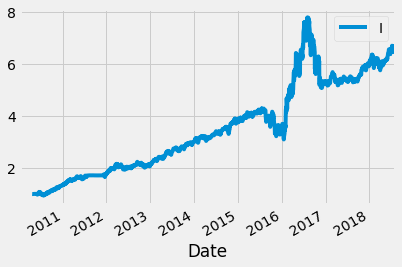

TotaAnnReturn = 64.127368
CAGR = 23.420000
Sharpe Ratio = 1.080000
Standard Deviation = 0.014905


In [84]:
testing_4 = stock_etf_optimized_parameters_full_dataset_top_ETF_only()